In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("theappname").getOrCreate()
df = spark.read.csv('/Code/spark/LAB4/data/20*.csv', mode="DROPMALFORMED", inferSchema=True, header = True)

from pyspark.sql.functions import  length, lpad
from pyspark.sql.types import IntegerType
selection = df\
    .where((df.Diverted == 0) & (df.CancellationCode.isNull()) & (df.TailNum.rlike("^([A-Z]|[a-z]|[0-9])"
                                                                                                                  "+$")) & ((length(df.DepTime) == 4) | (length(df.DepTime) == 3)) & (length(df.ArrTime) == 4) | (length(df.ArrTime) == 3))\
    .where(df['TailNum'].isNotNull())\
    .withColumn("DepTime", when(length(df.DepTime) == 3, lpad(df['DepTime'], 4,'0')).otherwise(df['DepTime']))\
    .withColumn("ArrTime", when(length(df.ArrTime) == 3, lpad(df['ArrTime'], 4,'0')).otherwise(df['ArrTime']))\
    .sort(asc('Year'), 'Month', 'DayofMonth', 'ArrTime')\
    .withColumn("ArrDelay", df.ArrDelay.cast(IntegerType()))\
    .withColumn("DepDelay", df["DepDelay"].cast(IntegerType()))\
    .withColumn("CarrierDelay", df["CarrierDelay"].cast(IntegerType()))\
    .withColumn("WeatherDelay", df["WeatherDelay"].cast(IntegerType()))\
    .withColumn("NASDelay", df["NASDelay"].cast(IntegerType()))\
    .withColumn("SecurityDelay", df["SecurityDelay"].cast(IntegerType()))\
    .withColumn("LateAircraftDelay", df["LateAircraftDelay"].cast(IntegerType()))\
    .fillna(0, subset=['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' ])


from pyspark.sql.functions import lag
from pyspark.sql.types import BinaryType
from pyspark.sql import Window
#w = Window.orderBy("Year", "Month", "DayofMonth", "ArrTime")
w = Window.partitionBy ("Year", "Month", "DayofMonth", "ArrTime").orderBy("Year", "Month", "DayofMonth", "ArrTime")

udf(returnType=BinaryType())
IsLate  = lambda x : x["ArrDelay"] > 15

base = selection \
    .withColumn("NbrOfPreviousLateFlights",(lag(selection['ArrDelay'], 1,0).over(w)  > 15 if 1 else 0).cast(IntegerType()) + (lag(selection['ArrDelay'], 2,0).over(w)  > 15 if 1 else 0).cast(IntegerType()) + (lag(selection['ArrDelay'], 3,0).over(w)  > 15 if 1 else 0).cast(IntegerType()))\
    .withColumn("IsLate", (IsLate(selection)))


In [14]:
superBasePanda = base.toPandas()
base.unpersist()
from pandas import notnull
superBasePanda = superBasePanda.where(superBasePanda['TailNum'].notnull())


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pandas import notnull
# Split the data into training and testing sets
lb_make = LabelEncoder()
basePanda = superBasePanda[['Year', 'Month', 'DayofMonth', 'DepTime', 'Origin', 'Dest', 'TailNum','UniqueCarrier','TaxiOut', 'DepDelay','Distance', 'LateAircraftDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','NbrOfPreviousLateFlights', 'IsLate']]
basePanda = basePanda.dropna()
basePanda['Origin_code'] = lb_make.fit_transform (basePanda['Origin'])
basePanda['Dest_code'] = lb_make.fit_transform (basePanda['Dest'])
basePanda['UniqueCarrier_code'] = lb_make.fit_transform (basePanda['UniqueCarrier'])
basePanda['TailNum_code'] = lb_make.fit_transform (basePanda['TailNum'])
#basePanda['ArrTime_code'] = lb_make.fit_transform (basePanda['ArrTime'])
basePanda['DepTime_code'] = lb_make.fit_transform (basePanda['DepTime'])
basePanda['TaxiOut_code'] = lb_make.fit_transform (basePanda['TaxiOut'])
basePanda = basePanda.drop('Origin', axis = 1) 
basePanda = basePanda.drop('Dest', axis = 1)
basePanda = basePanda.drop('UniqueCarrier', axis = 1) 
basePanda = basePanda.drop('TailNum', axis = 1) 
#basePanda = basePanda.drop('CancellationCode', axis = 1)
#basePanda = basePanda.drop('ArrTime', axis = 1)
basePanda = basePanda.drop('DepTime', axis = 1)
basePanda = basePanda.drop('TaxiOut', axis = 1)
labels = np.array(basePanda['IsLate'])
  

features = basePanda.drop('IsLate', axis = 1) 
#features = basePanda.get_dummies(features)


In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=6,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

sfs.fit(features, labels)
sfs.k_feature_names_ 


('DepDelay',
 'LateAircraftDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'DepTime_code')

c:\users\matsa\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\matsa\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


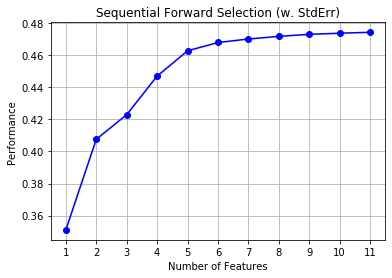

In [6]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

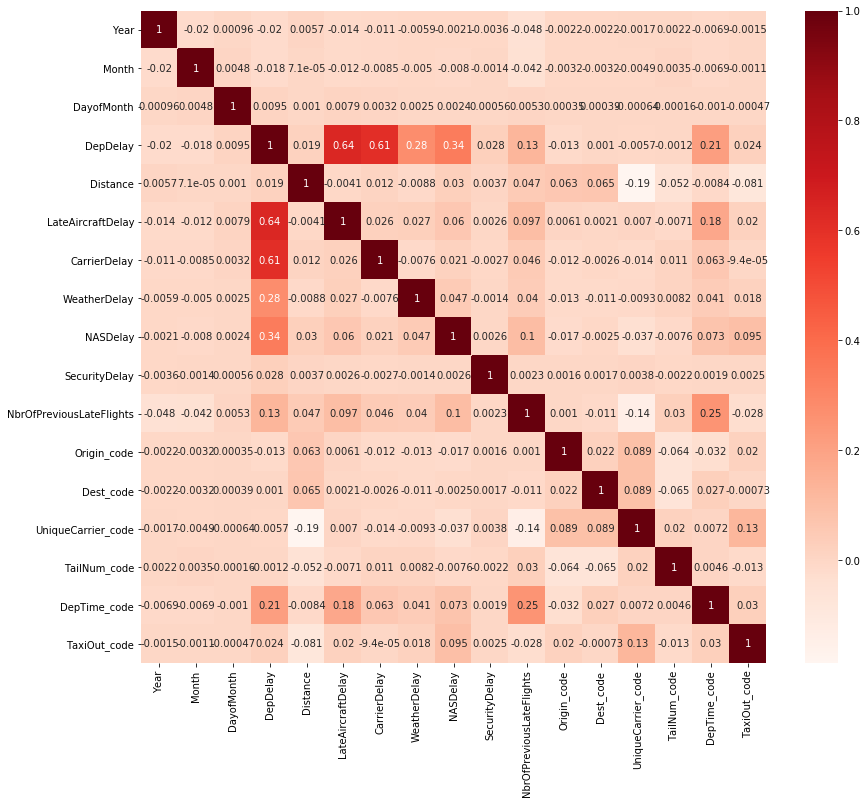

In [25]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
corr = features.corr()

plt.figure(figsize=(14,12))
sb.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
corr_target= np.abs(corr["DepDelay"])
selected_features = corr_target[corr_target>0.1]

In [27]:
selected_features.axes[0].tolist()

['DepDelay',
 'LateAircraftDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'NbrOfPreviousLateFlights',
 'DepTime_code']

In [28]:
features = basePanda[selected_features.axes[0].tolist()]

In [37]:
list(sfs.k_feature_names_)

    

DepDelay
LateAircraftDelay
CarrierDelay
WeatherDelay
NASDelay


In [17]:
features = basePanda[list(sfs.k_feature_names_)]

In [29]:
# Convert from pandas to array to match the 'train_test_split' method
features = np.array(features)
# split the features/labels into train and test sets 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [30]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 4, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print("Decision tree score: {:.4f} ".format(rf.score(test_features, test_labels)))

from time import gmtime, strftime
from sklearn.metrics import roc_auc_score

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
#errors = np.abs(predictions - test_labels)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', np.round(np.mean(errors), 2))
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Decision tree score: 1.00 
2019-12-30 13:41:25


In [35]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions, target_names=['Not late','Late'], digits=4))

              precision    recall  f1-score   support

    Not late     0.9995    0.9998    0.9997   2714745
        Late     0.9994    0.9984    0.9989    770126

    accuracy                         0.9995   3484871
   macro avg     0.9995    0.9991    0.9993   3484871
weighted avg     0.9995    0.9995    0.9995   3484871



In [33]:
# calculate the probalistics
rf_probs = rf.predict_proba(test_features)[:, 1]
# calculate the roc auc score to se the performance of the DR
roc_value = roc_auc_score(test_labels, rf_probs)

print("roc auc score: {:.4f} ".format(roc_value))

roc auc score: 0.9996 
